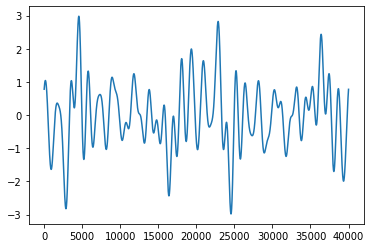

In [1]:
from Systems import DuffingOscillator
import deepSI
from matplotlib import pyplot as plt

u = deepSI.deepSI.exp_design.multisine(40000, pmax=41)
plt.plot(u)

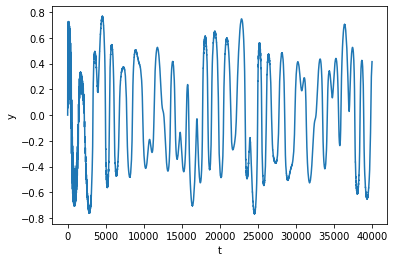

In [2]:
sys = DuffingOscillator()
data = sys.apply_experiment(deepSI.System_data(u=u))
data.plot()

In [7]:
ss_enc = deepSI.fit_systems.SS_encoder(nx=2, na=2, nb=2, feedthrough=False)
train, test = data.train_test_split(split_fraction=0.2)
train, val  = train.train_test_split(split_fraction=0.25)

ss_enc.fit(train_sys_data=train, val_sys_data=val, epochs=20, batch_size=256, loss_kwargs={'nf':150})

Initilizing the model and optimizer
Size of the training array =  55.3 MB
N_training_samples = 23849, batch_size = 256, N_batch_updates_per_epoch = 93
Initial Validation sim-NRMS= 1.6161425323431358


  0%|          | 0/20 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.12569336563734138
Epoch    1, sqrt loss  0.3868, Val sim-NRMS 0.1257, Time Loss: 92.3%, data: 0.3%, val: 7.4%,  3.1 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.03700917819773569
Epoch    2, sqrt loss  0.1204, Val sim-NRMS 0.03701, Time Loss: 92.3%, data: 0.2%, val: 7.5%,  3.3 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.026864059082466637
Epoch    3, sqrt loss 0.08746, Val sim-NRMS 0.02686, Time Loss: 92.5%, data: 0.2%, val: 7.4%,  3.5 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.025820139000458774
Epoch    4, sqrt loss 0.08645, Val sim-NRMS 0.02582, Time Loss: 92.2%, data: 0.2%, val: 7.7%,  3.5 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.023244448094429885
Epoch    5, sqrt loss  0.0858, Val sim-NRMS 0.02324, Time Loss: 92.3%, data: 0.2%, val: 7.5%,  3.5 batch

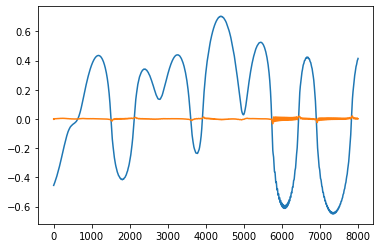

In [114]:
test_ss_enc = ss_enc.apply_experiment(test)

plt.plot(test.y)
plt.plot(test.y - test_ss_enc.y)

In [115]:
ss_enc.fn

simple_res_net(
  (net_lin): Linear(in_features=3, out_features=2, bias=True)
  (net_non_lin): feed_forward_nn(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)

In [116]:
from casadi import *

def CasADiFn(ss_enc):
    n_hidden_layers = ss_enc.f_n_hidden_layers
    nu = ss_enc.nu if ss_enc.nu is not None else 1

    params = {}
    for name, param in ss_enc.fn.named_parameters():
        params[name] = param.detach().numpy()
    params_list = list(params.values())

    x = MX.sym("x",ss_enc.nx,1)
    u = MX.sym("u",nu,1)
    xu = vertcat(x,u)

    temp_nn = xu
    for i in range(n_hidden_layers):
        W_NL = params_list[2+i*2]
        b_NL = params_list[3+i*2]
        temp_nn = mtimes(W_NL, temp_nn)+b_NL
        temp_nn = tanh(temp_nn)
    W_NL = params_list[2+n_hidden_layers*2]
    b_NL = params_list[3+n_hidden_layers*2]
    nn_NL = mtimes(W_NL, temp_nn)+b_NL

    W_Lin = params_list[0]
    b_Lin = params_list[1]
    nn_Lin = mtimes(W_Lin,xu) + b_Lin

    f = Function('f', [x, u], [nn_NL + nn_Lin])
    return f

In [117]:
f = CasADiFn(ss_enc)
f([0,0], 0)

DM([0.213049, 0.127114])

In [118]:
import torch
xt = torch.tensor([0,0,0], dtype=torch.float)
net = ss_enc.fn
net(xt).detach().numpy()

array([0.21304905, 0.12711373], dtype=float32)

In [162]:
def checkCasADiFn(ss_enc, casadi_fn):
    nu = 1000
    u = (torch.rand(nu,3)*2-1)*2
    ss_out = ss_enc.fn(u).detach().numpy()

    check = True
    for i in range(nu):
        xin = u[i,0:2].numpy().tolist()
        uin = u[i,2].item()
        cas_out = f(xin, uin).elements()
        equality_array = np.unique(np.round(np.array(cas_out) - ss_out[i,:], decimals=5) == 0.00000)
        if equality_array.size != 1 or equality_array[0] == False:
            check = False

    return check

In [163]:
check = checkCasADiFn(ss_enc, f)
check

True